In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.spatial import distance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Mount & Read File From Drive

Bisa dirubah jika tidak ingin membaca file dari drive dengan :


dataset = pd.read_csv("path or filename(jika dalam satu folder)")

In [2]:
from google.colab import drive #mount drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/Dataset.csv'
dataset = pd.read_csv(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Eksplorasi Data & Data Preparation**

In [0]:
dataset = dataset[['height_cm','weight_kg']]

In [4]:
dataset.head()

,height_cm,weight_kg
0,170,72
1,187,83
2,175,68
3,188,87
4,175,74


1. Melihat dimensi data

In [5]:
dataset.shape

(18278, 2)

2. Melihat tipe data dari masing-masing kolom

In [6]:
dataset.dtypes

height_cm    int64
weight_kg    int64
dtype: object

3. Missing Value

In [7]:
dataset.describe()

,height_cm,weight_kg
count,18278.000000,18278.000000
mean,181.362184,75.276343
std,6.756961,7.047744
min,156.000000,50.000000
25%,177.000000,70.000000
50%,181.000000,75.000000
75%,186.000000,80.000000
max,205.000000,110.000000


In [8]:
print(dataset.isnull().sum())

height_cm    0
weight_kg    0
dtype: int64


tidak ada missing value

4. Outlier

<Figure size 4200x4200 with 0 Axes>

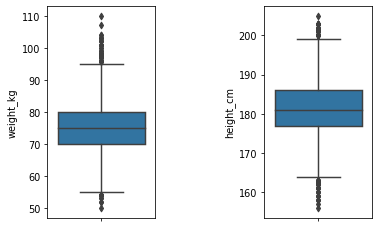

In [9]:
mpl.rcParams['figure.dpi'] = 70
plt.figure(figsize=(60, 60))
f, axes = plt.subplots(1, 2)
sns.boxplot(y=dataset["weight_kg"], ax=axes[0])
sns.boxplot(y=dataset["height_cm"], ax=axes[1])
plt.subplots_adjust(wspace=1)

# dataset.plot(kind='box', subplots=True, layout=(1,9), sharex=False, sharey=False)
# # plt.xticks(rotation=90)
# plt.show()

outlier ada, tapi masih termasuk data yang wajar. nilai outlier diambil dari quartil, tapi bukan berarti data yang termasuk outlier itu tidak mungkin.

## **Model 1**

## **Pemodelan**

1. Penambahan kolom cluster untuk memudahkan

In [0]:
dataset = pd.DataFrame(dataset, columns=['height_cm', 'weight_kg', 'cluster'])
data = dataset.copy()
#membuat kolom cluster yang diisi dengan -1
temp = []
for i in range(len(dataset['height_cm'])):
    temp.append(-1)
    
dataset['cluster'] = temp

2. visualisasi data

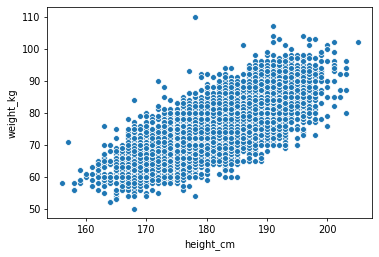

In [11]:
sns.scatterplot(x='height_cm', y='weight_kg', data=dataset)

3. Pembuatan centroid dengan K = 3

In [12]:
centro = [
    [0, 0, '0'],
    [0, 0, '1'],
    [0, 0, '2'],
]
# kita buat menjadi dataframe
centroid = pd.DataFrame(centro, columns=['height_cm', 'weight_kg', 'cluster'])

height_cm = []
weight_kg = []
x0 = np.random.randint(min(dataset['height_cm']),max(dataset['height_cm']))
y0 = np.random.randint(min(dataset['weight_kg']),max(dataset['weight_kg']))
x1 = np.random.randint(min(dataset['height_cm']),max(dataset['height_cm']))
y1 = np.random.randint(min(dataset['weight_kg']),max(dataset['weight_kg']))
x2 = np.random.randint(min(dataset['height_cm']),max(dataset['height_cm']))
y2 = np.random.randint(min(dataset['weight_kg']),max(dataset['weight_kg']))

height_cm.append(x0)
height_cm.append(x1)
height_cm.append(x2)
weight_kg.append(y0)
weight_kg.append(y1)
weight_kg.append(y2)

centroid['height_cm'] = height_cm
centroid['weight_kg'] = weight_kg
centroid

,height_cm,weight_kg,cluster
0,176,101,0
1,158,60,1
2,190,78,2


penentuan centroid awal mempengaruhi hasil akhir clustering

4. Memasukkan centroid sesuai titiknya

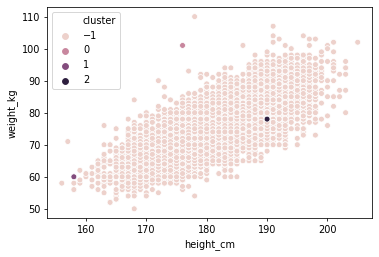

In [13]:
sns.scatterplot(x='height_cm', y='weight_kg', hue='cluster', data=dataset.append(centroid))

cluster -1 artinya adalah belum masuk ke dalam salah satu cluster (bisa diganti angka lain)

5. Pembuatan data untuk pergantian centroid

In [14]:
update = [
    [0, 0, '0'],
    [0, 0, '1'],
    [0, 0, '2'],
]

# kita buat menjadi dataframe
centroidBaru = pd.DataFrame(update, columns=['height_cm', 'weight_kg', 'cluster'])
centroidBaru

,height_cm,weight_kg,cluster
0,0,0,0
1,0,0,1
2,0,0,2


6. Proses clustering dan perubahan titik centroid (dilakukan hingga posisi titik centroid sudah tidak berpindah lagi)

In [0]:
notSame = True
j = 1
while (notSame is True): #akan melakukan looping selama "notSame " bernilai True (titik centroid sudah tidak berubah)
    clusterr = []
    baru  = []

    x02, y02 = centroid.iloc[0][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 0
    x12, y12 = centroid.iloc[1][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 1
    x22, y22 = centroid.iloc[2][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 2

    #mencari centroid terdekat dengan setiap titik
    for i in range(len(dataset)):
        x1, y1 = dataset.iloc[i][['height_cm', 'weight_kg']] #mengambil titik untuk setiap data pada dataset

        # euclidean distant
        dist0 = np.sqrt(pow((x02-x1),2) + pow((y02-y1),2))
        dist1 = np.sqrt(pow((x12-x1),2) + pow((y12-y1),2))
        dist2 = np.sqrt(pow((x22-x1),2) + pow((y22-y1),2))

        if (dist0 < dist1) and (dist0 < dist2):
            hasil = '0'
        elif  (dist1 < dist0) and (dist1 < dist2):
            hasil = '1'
        elif  (dist2 < dist0) and (dist2 < dist1):
            hasil = '2'
        clusterr.append(hasil)
    
    #ganti kolom 'cluster' pada dataset dengan list clusterr tadi
    dataset['cluster'] = clusterr 
    
    #Update centroid
    x0 = dataset[dataset['cluster'] == '0']['height_cm'].tolist()
    y0 = dataset[dataset['cluster'] == '0']['weight_kg'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 0
    mean_x0 = np.mean(x0)
    mean_y0 = np.mean(y0)

    x1 = dataset[dataset['cluster'] == '1']['height_cm'].tolist()
    y1 = dataset[dataset['cluster'] == '1']['weight_kg'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 1
    mean_x1 = np.mean(x1)
    mean_y1 = np.mean(y1)

    x2 = dataset[dataset['cluster'] == '2']['height_cm'].tolist()
    y2 = dataset[dataset['cluster'] == '2']['weight_kg'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 2
    mean_x2 = np.mean(x2)
    mean_y2 = np.mean(y2)

    #mengganti nilai centroidBaru dengan mean yang sudah dihitung tadi
    centroidBaru.iloc[0,0] = mean_x0
    centroidBaru.iloc[0,1] = mean_y0
    centroidBaru.iloc[1,0] = mean_x1
    centroidBaru.iloc[1,1] = mean_y1
    centroidBaru.iloc[2,0] = mean_x2
    centroidBaru.iloc[2,1] = mean_y2

    #cek perubahan titik centroid
    if (centroidBaru.iloc[0,:2].all() != centroid.iloc[0,:2].all()):
        centroid,centroidBaru = centroidBaru, centroid 
    else:
        notSame = False
    # print('ini loop ke ', j)
    # j = j+1

In [16]:
centroidBaru

,height_cm,weight_kg,cluster
0,189.420222,84.156222,0
1,174.264691,68.189794,1
2,182.252239,75.677658,2


titik centroidnya sekarang seperti ini

7. Hasil Clustering

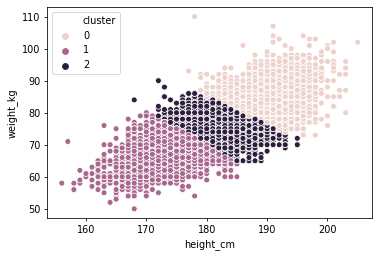

In [17]:
sns.scatterplot(x='height_cm', y='weight_kg', hue='cluster', data=dataset)

## **Evaluasi (SSE)**

perhitungan SSE dilakukan secara manual dengan menghitung 
kuadrat jarak dari tiap titik anggota cluster ke centroidnya masing-masing, lalu dijumlahkan. SSE merupakan hasil dari penjumlahan semua cluster

In [18]:
x02, y02 = centroid.iloc[0][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 0
x12, y12 = centroid.iloc[1][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 1
x22, y22 = centroid.iloc[2][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 2

nol = []
one = []
dua = []

#mengambil titik dari anggota cluster 0
x0 = dataset[dataset['cluster'] == '0']['height_cm'].tolist()
y0 = dataset[dataset['cluster'] == '0']['weight_kg'].tolist()

#menghitung jarak lalu dikuadratkan (akar hilang)
for i in range(len(x0)):
    dist0 = (pow((x02-x0[i]),2) + pow((y02-y0[i]),2))
    nol.append(dist0)

#mengambil titik dari anggota cluster 1
x1 = dataset[dataset['cluster'] == '1']['height_cm'].tolist()
y1 = dataset[dataset['cluster'] == '1']['weight_kg'].tolist()

#menghitung jarak lalu dikuadratkan (akar hilang)
for j in range(len(x1)):
    dist1 = (pow((x12-x1[j]),2) + pow((y12-y1[j]),2))
    one.append(dist1)

#mengambil titik dari anggota cluster 2            
x2 = dataset[dataset['cluster'] == '2']['height_cm'].tolist()
y2= dataset[dataset['cluster'] == '2']['weight_kg'].tolist()

#menghitung jarak lalu dikuadratkan (akar hilang)
for k in range(len(x2)):
    dist2 = (pow((x22-x2[k]),2) + pow((y22-y2[k]),2))
    dua.append(dist2)

c0 = sum(nol)
c1 = sum(one)
c2 = sum(dua)

print('SSE Model Pertama :',c0+c1+c2)

SSE Model Pertama : 476817.602916542


Model pertama selesai

## **Model 2**

## **Pemodelan**

1. Penambahan kolom cluster untuk memudahkan

In [0]:
dataset2 = data.copy()

In [0]:
dataset2 = pd.DataFrame(dataset2, columns=['height_cm', 'weight_kg', 'cluster'])

#membuat kolom cluster yang diisi dengan -1
temp = []
for i in range(len(dataset2['height_cm'])):
    temp.append(-1)
    
dataset2['cluster'] = temp

2. visualisasi data

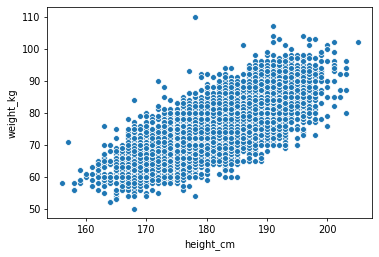

In [21]:
sns.scatterplot(x='height_cm', y='weight_kg', data=dataset2)

3. Pembuatan centroid dengan K = 2

In [22]:
centro2 = [
    [0, 0, '0'],
    [0, 0, '1'],
]
# kita buat menjadi dataframe
centroid2 = pd.DataFrame(centro2, columns=['height_cm', 'weight_kg', 'cluster'])

height_cm = []
weight_kg = []
x0 = np.random.randint(min(dataset2['height_cm']),max(dataset2['height_cm']))
y0 = np.random.randint(min(dataset2['weight_kg']),max(dataset2['weight_kg']))
x1 = np.random.randint(min(dataset2['height_cm']),max(dataset2['height_cm']))
y1 = np.random.randint(min(dataset2['weight_kg']),max(dataset2['weight_kg']))
height_cm.append(x0)
height_cm.append(x1)
weight_kg.append(y0)
weight_kg.append(y1)

centroid2['height_cm'] = height_cm
centroid2['weight_kg'] = weight_kg
centroid2

,height_cm,weight_kg,cluster
0,183,102,0
1,166,65,1


penentuan centroid awal mempengaruhi hasil akhir clustering

4. Memasukkan centroid sesuai titiknya

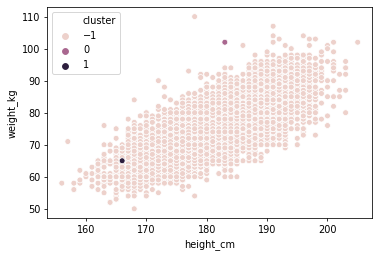

In [23]:
sns.scatterplot(x='height_cm', y='weight_kg', hue='cluster', data=dataset2.append(centroid2))

cluster -1 artinya adalah belum masuk ke dalam salah satu cluster (bisa diganti angka lain)

5. Pembuatan data untuk pergantian centroid

In [24]:
update2 = [
    [0, 0, '0'],
    [0, 0, '1'],
]

# kita buat menjadi dataframe
centroidBaru2 = pd.DataFrame(update2, columns=['height_cm', 'weight_kg', 'cluster'])
centroidBaru2

,height_cm,weight_kg,cluster
0,0,0,0
1,0,0,1


6. Proses clustering dan perubahan titik centroid (dilakukan hingga posisi titik centroid sudah tidak berpindah lagi)

In [0]:
notSame = True
j = 1
while (notSame is True): #akan melakukan looping selama "notSame " bernilai True (titik centroid sudah tidak berubah)
    clusterr = []
    baru  = []

    x02, y02 = centroid2.iloc[0][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 0
    x12, y12 = centroid2.iloc[1][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 1

    #mencari centroid terdekat dengan setiap titik
    for i in range(len(dataset2)):
        x1, y1 = dataset2.iloc[i][['height_cm', 'weight_kg']] #mengambil titik untuk setiap data pada dataset2

        # euclidean distant
        dist0 = np.sqrt(pow((x02-x1),2) + pow((y02-y1),2))
        dist1 = np.sqrt(pow((x12-x1),2) + pow((y12-y1),2))

        if (dist0 < dist1):
            hasil = '0'
        elif  (dist1 < dist0):
            hasil = '1'
        clusterr.append(hasil)

    #ganti kolom 'cluster' pada dataset2 dengan list clusterr tadi
    dataset2['cluster'] = clusterr 
    
    #Update centroid
    x0 = dataset2[dataset2['cluster'] == '0']['height_cm'].tolist()
    y0 = dataset2[dataset2['cluster'] == '0']['weight_kg'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 0
    mean_x0 = np.mean(x0)
    mean_y0 = np.mean(y0)

    x1 = dataset2[dataset2['cluster'] == '1']['height_cm'].tolist()
    y1 = dataset2[dataset2['cluster'] == '1']['weight_kg'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 1
    mean_x1 = np.mean(x1)
    mean_y1 = np.mean(y1)

    #mengganti nilai centroidBaru dengan mean yang sudah dihitung tadi
    centroidBaru2.iloc[0,0] = mean_x0
    centroidBaru2.iloc[0,1] = mean_y0
    centroidBaru2.iloc[1,0] = mean_x1
    centroidBaru2.iloc[1,1] = mean_y1

    #cek perubahan titik centroid
    if (centroidBaru2.iloc[0,:2].all() != centroid2.iloc[0,:2].all()):
        centroid2,centroidBaru2 = centroidBaru2, centroid2 
    else:
        notSame = False
    # print('ini loop ke ', j)
    # j = j+1

In [26]:
centroidBaru2

,height_cm,weight_kg,cluster
0,186.914661,80.976171,0
1,176.515217,70.300748,1


titik centroidnya sekarang seperti ini

7. Hasil Clustering

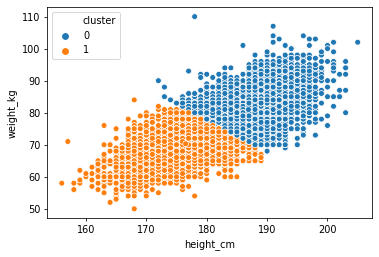

In [27]:
sns.scatterplot(x='height_cm', y='weight_kg', hue='cluster', data=dataset2.append(centroid2))

## **Evaluasi (SSE)**

perhitungan SSE dilakukan secara manual dengan menghitung 
kuadrat jarak dari tiap titik anggota cluster ke centroidnya masing-masing, lalu dijumlahkan. SSE merupakan hasil dari penjumlahan semua cluster

In [28]:
x02, y02 = centroidBaru2.iloc[0][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 0
x12, y12 = centroidBaru2.iloc[1][['height_cm', 'weight_kg']] #mengambil titik Centroid ke 1

nol = []
one = []

#mengambil titik dari anggota cluster 0
x0 = dataset2[dataset2['cluster'] == '0']['height_cm'].tolist()
y0 = dataset2[dataset2['cluster'] == '0']['weight_kg'].tolist()

#menghitung jarak lalu dikuadratkan (akar hilang)
for i in range(len(x0)):
    dist0 = (pow((x02-x0[i]),2) + pow((y02-y0[i]),2))
    nol.append(dist0)

#mengambil titik dari anggota cluster 1
x1 = dataset2[dataset2['cluster'] == '1']['height_cm'].tolist()
y1 = dataset2[dataset2['cluster'] == '1']['weight_kg'].tolist()

#menghitung jarak lalu dikuadratkan (akar hilang)
for j in range(len(x1)):
    dist1 = (pow((x12-x1[j]),2) + pow((y12-y1[j]),2))
    one.append(dist1)

c0 = sum(nol)
c1 = sum(one)

print('SSE Model Kedua',c0+c1)

SSE Model Kedua 732020.9163491626


Model kedua selesai

## Elbow Method

hanya digunakan untuk melihat nilai k optimal bukan untuk evaluasi

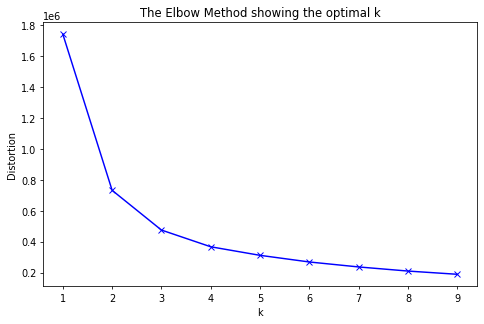

In [29]:
from sklearn.cluster import KMeans
data = dataset.drop(columns=['cluster'])

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

dapat dilihat bahwa, nilai k yang optimal adalah 3